In [136]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import config as cfg
import numpy as np
import matplotlib.pyplot as plt
from utils import build_trip_count, get_district_names, get_income_data, add_quantiles

In [137]:
all_viajes = pd.read_csv('/Users/caro/Desktop/thesis_project/mobility_data/VIAJES/all_viajes_month_0322.csv') # all trips
income = gpd.read_file('/Users/caro/Desktop/thesis_project/segregation_indices/data/processed/geometries_and_income.geojson') # income data
gdf = gpd.read_file(cfg.ZONIFICACION_DATA / 'distritos/madrid_gdf.geojson') # geodataframe
# gdf = gdf.to_crs(epsg=4326)
district_mapping = pd.read_csv('/Users/caro/Desktop/thesis_project/data_overview/outputs/districts_and_population.csv')

In [138]:
all_viajes.actividad_destino.value_counts()

actividad_destino
frecuente          7268863
casa               4933456
no_frecuente       4920539
trabajo_estudio    2778097
Name: count, dtype: int64

In [139]:
all_viajes.head()

,fecha,periodo,origen,destino,distancia,actividad_origen,actividad_destino,estudio_origen_posible,estudio_destino_posible,residencia,renta,edad,sexo,viajes,viajes_km
0,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,0-25,hombre,29.337,30.222
1,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,0-25,mujer,34.143,27.522
2,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,25-45,hombre,92.799,63.331
3,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,25-45,mujer,65.475,44.556
4,20220301,0,2807901,2807901,0.5-2,casa,frecuente,no,no,28,>15,45-65,hombre,44.319,31.052


In [140]:
filtered_df = all_viajes.loc[(all_viajes['actividad_origen'] == 'casa')] # home origin trips

In [141]:
filtered_df.shape

(4839108, 15)

In [142]:
home_work = all_viajes[ # home to work trips
    ((all_viajes['actividad_origen'] == 'casa') & (all_viajes['actividad_destino'] == 'trabajo_estudio'))
]

In [143]:
home_work.shape

(1205740, 15)

## Filtering trips by median income quantile

1. Do low median income quantiles travel more to high median income quantiles for work purposes and overall?
2. Do low median income quantiles travel more distance on average than other median income quantiles for work purposes and overall?

Question 1, all trips with home origin:

In [144]:
trip_counts = build_trip_count(filtered_df, 'distancia')
trip_counts = get_district_names(trip_counts)
trip_counts = get_income_data(trip_counts, income, 'Gini Index', 'Median income per consumption unit')
trip_counts = add_quantiles(trip_counts, 'Median income per consumption unit', n_quantiles=4)
trip_counts = add_quantiles(trip_counts, 'Gini Index', n_quantiles=4)

In [145]:
trip_counts.trip_count.sum()

np.int64(4839108)

In [146]:
low_to_high_median = trip_counts[(trip_counts['income decile origin Median income per consumption unit'].isin([0, 1])) & 
                                      (trip_counts['income decile destination Median income per consumption unit'].isin([2, 3]))]

high_to_low_median = trip_counts[(trip_counts['income decile origin Median income per consumption unit'].isin([2, 3])) & 
                                      (trip_counts['income decile destination Median income per consumption unit'].isin([0, 1]))]

In [147]:
# percentage of trips from low to high districts (median income per consumtion unit)
low_to_high_median['trip_count'].sum() / trip_counts.trip_count.sum() * 100 

np.float64(26.116094123131784)

In [148]:
# percentage of trips from high to low districts (median income per consumtion unit)
high_to_low_median['trip_count'].sum() / trip_counts.trip_count.sum() * 100

np.float64(15.278022313203177)

Question 2, all trips with home origin:

In [149]:
low_median_income = trip_counts[trip_counts['income decile origin Median income per consumption unit'].isin([0, 1])]
high_median_income = trip_counts[trip_counts['income decile origin Median income per consumption unit'].isin([2, 3])]

In [154]:
distance_order = ['0.5-2', '2-10', '10-50']
colors = ["#a6cee3", "#03396c"]

In [155]:
low_income_distances = low_median_income['distancia'].value_counts(normalize=True).sort_index().reindex(distance_order, fill_value=0)
high_income_distances = high_median_income['distancia'].value_counts(normalize=True).sort_index().reindex(distance_order, fill_value=0)

In [156]:
distance_comparison = pd.DataFrame({
    'Low Median Income Distances': low_income_distances,
    'High Median Income Distances': high_income_distances
})

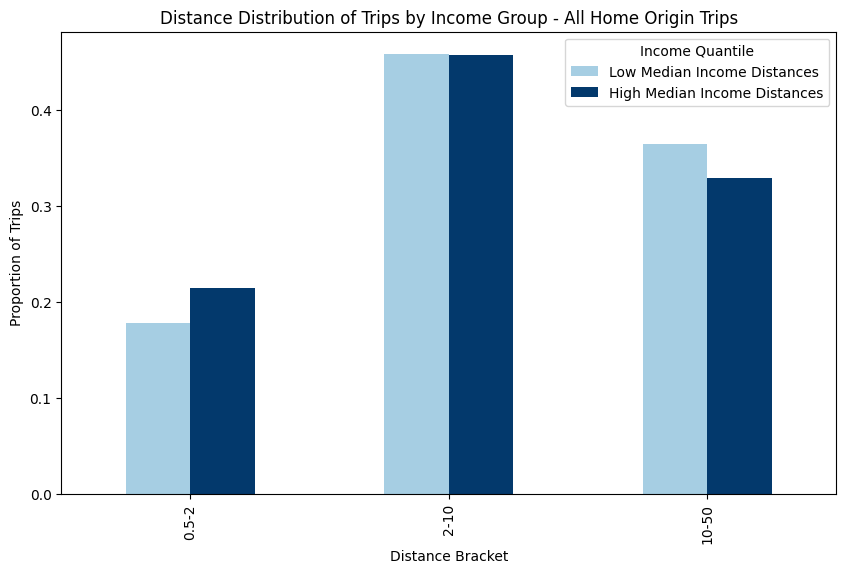

In [157]:
fig, ax = plt.subplots(figsize=(10, 6))
distance_comparison.plot(kind='bar', color=colors, ax=ax)
plt.title('Distance Distribution of Trips by Income Group - All Home Origin Trips')
plt.xlabel('Distance Bracket')
plt.ylabel('Proportion of Trips')
plt.legend(title='Income Quantile')
plt.show()

Question 1, home to work:

In [109]:
trip_counts_work = build_trip_count(home_work, 'distancia')
trip_counts_work = get_district_names(trip_counts_work)
trip_counts_work = get_income_data(trip_counts_work, income, 'Gini Index', 'Median income per consumption unit')
trip_counts_work = add_quantiles(trip_counts_work, 'Median income per consumption unit')
trip_counts_work = add_quantiles(trip_counts_work, 'Gini Index')

In [110]:
low_to_high_median = trip_counts_work[(trip_counts_work['income decile origin Median income per consumption unit'].isin([0, 1])) & 
                                      (trip_counts_work['income decile destination Median income per consumption unit'].isin([4, 5]))]

high_to_low_median = trip_counts_work[(trip_counts_work['income decile origin Median income per consumption unit'].isin([4, 5])) & 
                                      (trip_counts_work['income decile destination Median income per consumption unit'].isin([0, 1]))]

In [111]:
low_to_high_median['trip_count'].sum() / trip_counts_work.trip_count.sum() * 100 

np.float64(13.026440194403438)

In [112]:
high_to_low_median['trip_count'].sum() / trip_counts_work.trip_count.sum() * 100 

np.float64(6.146184086121386)

Question 2, home to work:

In [113]:
low_median_income_work = trip_counts_work[trip_counts_work['income decile origin Median income per consumption unit'].isin([0, 1])]
mid_median_income_work = trip_counts_work[trip_counts_work['income decile origin Median income per consumption unit'].isin([2, 3])]
high_median_income_work = trip_counts_work[trip_counts_work['income decile origin Median income per consumption unit'].isin([4, 5])]

In [114]:
low_income_distances_work = low_median_income_work['distancia'].value_counts(normalize=True).sort_index().reindex(distance_order, fill_value=0)
mid_income_distances_work = mid_median_income_work['distancia'].value_counts(normalize=True).sort_index().reindex(distance_order, fill_value=0)
high_income_distances_work = high_median_income_work['distancia'].value_counts(normalize=True).sort_index().reindex(distance_order, fill_value=0)

In [115]:
distance_comparison_work = pd.DataFrame({
    'Low Median Income Distances': low_income_distances_work,
    'Mid Median Income Distances': mid_income_distances_work,
    'High Median Income Distances': high_income_distances_work
})

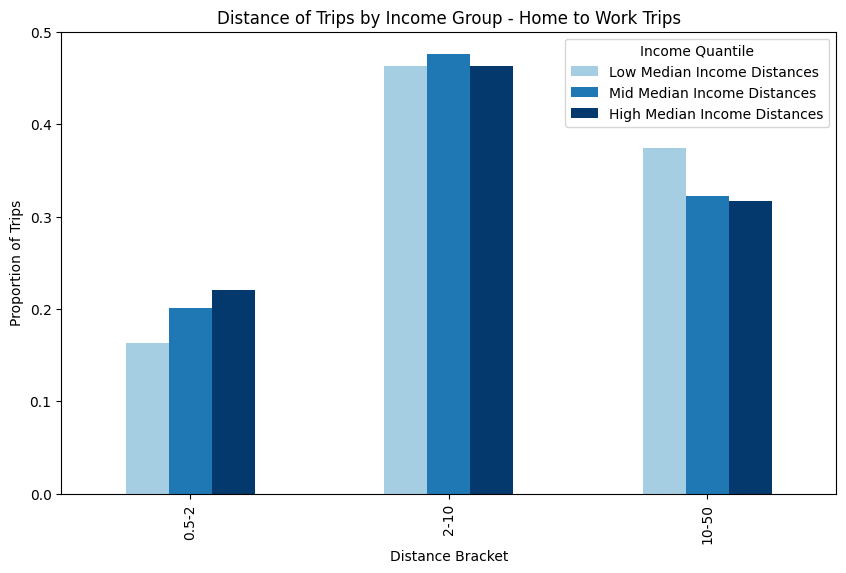

In [116]:
fig, ax = plt.subplots(figsize=(10, 6))
distance_comparison_work.plot(kind='bar', color=colors, ax=ax)
plt.title('Distance of Trips by Income Group - Home to Work Trips')
plt.xlabel('Distance Bracket')
plt.ylabel('Proportion of Trips')
plt.legend(title='Income Quantile')
plt.show()

## Filtering trips by Gini Index quantile

Question 1, all trips with home origin, Gini Index:

In [117]:
low_to_high_gini = trip_counts[(trip_counts['income decile origin Gini Index'].isin([5, 4])) & 
                                      (trip_counts['income decile destination Gini Index'].isin([0, 1]))]

high_to_low_gini = trip_counts[(trip_counts['income decile origin Gini Index'].isin([0, 1])) & 
                                      (trip_counts['income decile destination Gini Index'].isin([5, 4]))]

In [118]:
# percentage of trips from low to high districts (gini index)
low_to_high_gini['trip_count'].sum() / trip_counts.trip_count.sum() * 100 

np.float64(4.186081401779005)

In [119]:
# percentage of trips from high to low districts (gini index)
high_to_low_gini['trip_count'].sum() / trip_counts.trip_count.sum() * 100 

np.float64(9.383898850779937)

Question 1, home to work, Gini Index:

In [120]:
low_to_high_gini_work = trip_counts_work[(trip_counts_work['income decile origin Gini Index'].isin([5, 4])) & 
                                      (trip_counts_work['income decile destination Gini Index'].isin([0, 1]))]

high_to_low_gini_work = trip_counts_work[(trip_counts_work['income decile origin Gini Index'].isin([0, 1])) & 
                                      (trip_counts_work['income decile destination Gini Index'].isin([5, 4]))]

In [121]:
low_to_high_gini_work['trip_count'].sum() / trip_counts_work.trip_count.sum() * 100 

np.float64(5.397764028729245)

In [122]:
high_to_low_gini_work['trip_count'].sum() / trip_counts_work.trip_count.sum() * 100 

np.float64(9.138703203012257)

Question 2, all trips with home origin, Gini Index:

In [123]:
low_median_income = trip_counts[trip_counts['income decile origin Gini Index'].isin([5, 4])]
mid_median_income = trip_counts[trip_counts['income decile origin Gini Index'].isin([3, 2])]
high_median_income = trip_counts[trip_counts['income decile origin Gini Index'].isin([1, 0])]

In [124]:
low_income_distances = low_median_income['distancia'].value_counts(normalize=True).sort_index().reindex(distance_order, fill_value=0)
mid_income_distances = mid_median_income['distancia'].value_counts(normalize=True).sort_index().reindex(distance_order, fill_value=0)
high_income_distances = high_median_income['distancia'].value_counts(normalize=True).sort_index().reindex(distance_order, fill_value=0)

In [125]:
distance_comparison_gini = pd.DataFrame({
    'Low Gini Distances': low_income_distances,
    'Mid Gini Distances': mid_income_distances,
    'High Gini Distances': high_income_distances
})

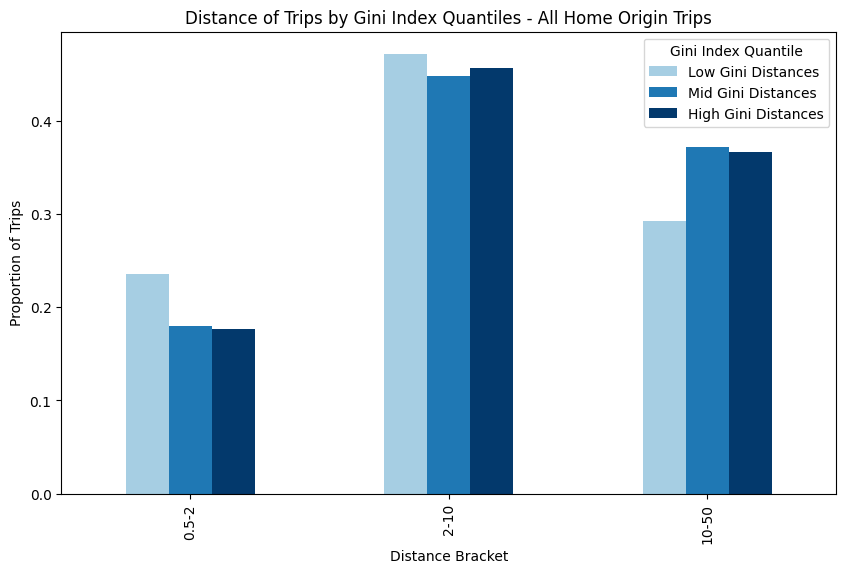

In [126]:
fig, ax = plt.subplots(figsize=(10, 6))

distance_comparison_gini.plot(kind='bar', color=colors, ax=ax)
plt.title('Distance of Trips by Gini Index Quantiles - All Home Origin Trips')
plt.xlabel('Distance Bracket')
plt.ylabel('Proportion of Trips')
plt.legend(title='Gini Index Quantile')
plt.show()

Question 2, home to work, Gini Index:

In [127]:
low_median_income = trip_counts_work[trip_counts_work['income decile origin Gini Index'].isin([5, 4])]
mid_median_income = trip_counts_work[trip_counts_work['income decile origin Gini Index'].isin([3, 2])]
high_median_income = trip_counts_work[trip_counts_work['income decile origin Gini Index'].isin([1, 0])]

In [128]:
low_income_distances_work = low_median_income_work['distancia'].value_counts(normalize=True).sort_index().reindex(distance_order, fill_value=0)
mid_income_distances_work = mid_median_income_work['distancia'].value_counts(normalize=True).sort_index().reindex(distance_order, fill_value=0)
high_income_distances_work = high_median_income_work['distancia'].value_counts(normalize=True).sort_index().reindex(distance_order, fill_value=0)

In [129]:
distance_comparison_gini_work = pd.DataFrame({
    'Low Gini Distances': low_income_distances_work,
    'Mid Gini Distances': mid_income_distances_work,
    'High Gini Distances': high_income_distances_work
})

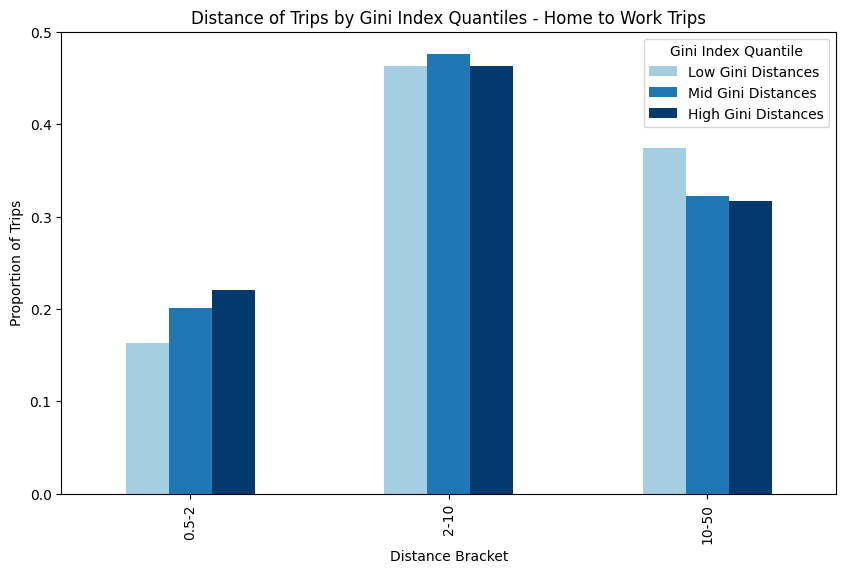

In [130]:
fig, ax = plt.subplots(figsize=(10, 6))
distance_comparison_gini_work.plot(kind='bar', color=colors, ax=ax)
plt.title('Distance of Trips by Gini Index Quantiles - Home to Work Trips')
plt.xlabel('Distance Bracket')
plt.ylabel('Proportion of Trips')
plt.legend(title='Gini Index Quantile')
plt.show()

## Further Analysis

In [131]:
distance_comparison

,Low Median Income Distances,Mid Median Income Distances,High Median Income Distances
distancia,,,
0.5-2,0.1675,0.203065,0.227941
2-10,0.4550,0.463602,0.455882
10-50,0.3775,0.333333,0.316176


In [132]:
distance_comparison_work

,Low Median Income Distances,Mid Median Income Distances,High Median Income Distances
distancia,,,
0.5-2,0.162850,0.200787,0.220149
2-10,0.463104,0.476378,0.462687
10-50,0.374046,0.322835,0.317164


In [133]:
distance_comparison_gini

,Low Gini Distances,Mid Gini Distances,High Gini Distances
distancia,,,
0.5-2,0.235955,0.180282,0.176849
2-10,0.471910,0.447887,0.456592
10-50,0.292135,0.371831,0.366559


In [134]:
distance_comparison_gini_work

,Low Gini Distances,Mid Gini Distances,High Gini Distances
distancia,,,
0.5-2,0.162850,0.200787,0.220149
2-10,0.463104,0.476378,0.462687
10-50,0.374046,0.322835,0.317164
